In [1]:
import control
import numpy as np
import matplotlib.pyplot as plt
import scipy
import kontrol
import vishack

prefix = "../data/ham4/ham4_all_sensors_"
suffix = ".xml"

dates = []  # All dates on feb, 2025. exclude 4th and 12th (outlier).
for i in range(1, 29):
    if i != 12 and i != 4:
        dates.append(f"202502{i:02d}")

datas = []
for date in dates:
    path = prefix + date + suffix
    datas.append(vishack.data.diaggui.Diaggui(path))

In [2]:
channels = [
    "L1:ISI-HAM4_BLND_GS13Y_IN1_DQ",
    "L1:ISI-HAM4_BLND_CPSY_IN1_DQ",
    "L1:ISI-GND_STS_ITMY_Y_DQ",
    "L1:ISI-HAM4_FF_Y_IN1_DQ",
]

# L4C and STS coherent subtraction gives seismometer noise
s = control.tf("s")
wn = 1*2*np.pi
q = 1/np.sqrt(2)
inert_cal = (s**2 + wn/q*s + wn**2) / s**3 * 1e-9

seis_cal = 1e-9 * 1/s

inertials = []
residuals = []
seismics = []

for data in datas:
    f, inert_raw = data.psd(channels[0])
    f, rel_raw = data.psd(channels[1])
    _, seis_raw = data.psd(channels[2])
    _, l4c_raw = data.psd(channels[3])
    _, coh = data.coh(channels[0], channels[2])
    
    inert = inert_raw * abs(inert_cal(1j*2*np.pi*f))
    residual = (inert**2 * (1-coh**.5))**.5
    seis = seis_raw * abs(seis_cal(1j*2*np.pi*f))
    inertials.append(inert)
    residuals.append(residual)
    seismics.append(seis)

In [3]:
# Find mean, sigma spectrums

def percentile_spectrum(spectrums, percentile):
    """Returns spectrum at percentile:
    
    Parameters
    ----------
    spectrums : list of array
        The spectrums.
    percentile : float
        The percentile.
    
    Returns
    -------
    quantile : array
        The spectrum at percentile.
    """
    spectrums = np.array(spectrums)
    log_spectrums = np.log10(spectrums)
    log_mean = np.mean(log_spectrums, axis=0)
    log_sigma = np.std(log_spectrums, axis=0)
    # quantile function
    log_quantile = log_mean + log_sigma*np.sqrt(2)*scipy.special.erfinv(2*percentile-1)
    quantile = 10**log_quantile
    
    return quantile

In [4]:
inert_50 = percentile_spectrum(inertials, 0.5)
inert_60 = percentile_spectrum(inertials, 0.60)
inert_70 = percentile_spectrum(inertials, 0.70)
inert_80 = percentile_spectrum(inertials, 0.8)
inert_90 = percentile_spectrum(inertials, 0.9)

residual_50 = percentile_spectrum(residuals, 0.5)
residual_60 = percentile_spectrum(residuals, 0.60)
residual_70 = percentile_spectrum(residuals, 0.70)
residual_80 = percentile_spectrum(residuals, 0.8)
residual_90 = percentile_spectrum(residuals, 0.9)

seismic_50 = percentile_spectrum(seismics, 0.5)
seismic_75 = percentile_spectrum(seismics, 0.75)
seismic_90 = percentile_spectrum(seismics, 0.90)
seismic_95 = percentile_spectrum(seismics, 0.95)
seismic_99 = percentile_spectrum(seismics, 0.99)

# Resample
f_ = np.logspace(-3, 2, 1024)

inert_50r = 10**np.interp(np.log10(f_), np.log10(f), np.log10(inert_50))
inert_60r = 10**np.interp(np.log10(f_), np.log10(f), np.log10(inert_60))
inert_70r = 10**np.interp(np.log10(f_), np.log10(f), np.log10(inert_70))
inert_80r = 10**np.interp(np.log10(f_), np.log10(f), np.log10(inert_80))
inert_90r = 10**np.interp(np.log10(f_), np.log10(f), np.log10(inert_90))

residual_50r = 10**np.interp(np.log10(f_), np.log10(f), np.log10(residual_50))
residual_60r = 10**np.interp(np.log10(f_), np.log10(f), np.log10(residual_60))
residual_70r = 10**np.interp(np.log10(f_), np.log10(f), np.log10(residual_70))
residual_80r = 10**np.interp(np.log10(f_), np.log10(f), np.log10(residual_80))
residual_90r = 10**np.interp(np.log10(f_), np.log10(f), np.log10(residual_90))

seismic_50r = 10**np.interp(np.log10(f_), np.log10(f), np.log10(seismic_50))
seismic_75r = 10**np.interp(np.log10(f_), np.log10(f), np.log10(seismic_75))
seismic_90r = 10**np.interp(np.log10(f_), np.log10(f), np.log10(seismic_90))
seismic_95r = 10**np.interp(np.log10(f_), np.log10(f), np.log10(seismic_95))
seismic_99r = 10**np.interp(np.log10(f_), np.log10(f), np.log10(seismic_99))

Text(0.5, 0, 'Frequency (Hz)')

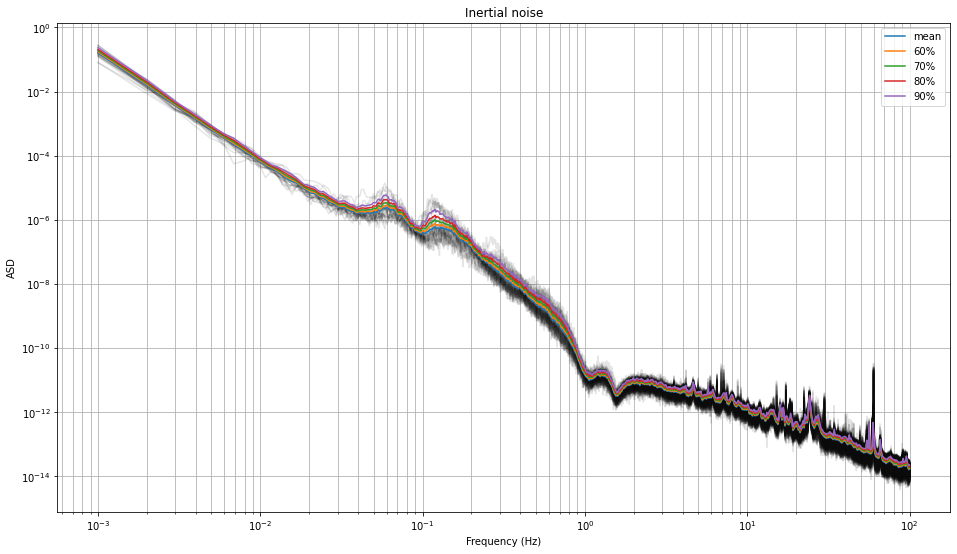

In [5]:
plt.figure(figsize=(16, 9))
plt.title("Inertial noise")

for inert in inertials:
    plt.loglog(f, inert, "k", alpha=0.1)
    
plt.loglog(f_, inert_50r, label="mean")
plt.loglog(f_, inert_60r, label="60%")
plt.loglog(f_, inert_70r, label="70%")
plt.loglog(f_, inert_80r, label="80%")
plt.loglog(f_, inert_90r, label="90%")

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD")
plt.xlabel("Frequency (Hz)")

Text(0.5, 0, 'Frequency (Hz)')

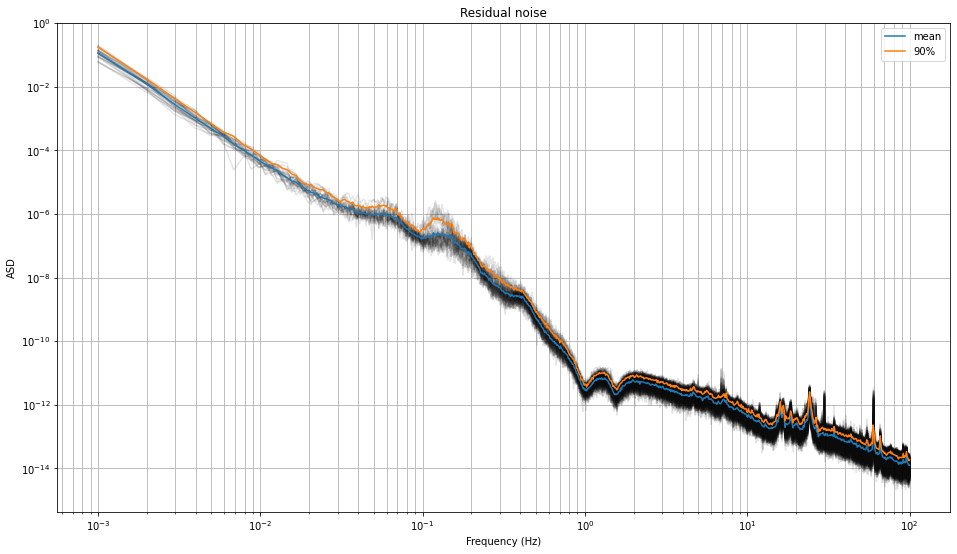

In [6]:
plt.figure(figsize=(16, 9))
plt.title("Residual noise")

for residual in residuals:
    plt.loglog(f, residual, "k", alpha=0.1)
    
plt.loglog(f_, residual_50r, label="mean")
# plt.loglog(f_, residual_60r, label="60%")
# plt.loglog(f_, residual_70r, label="70%")
# plt.loglog(f_, residual_80r, label="80%")
plt.loglog(f_, residual_90r, label="90%")

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD")
plt.xlabel("Frequency (Hz)")

Text(0.5, 0, 'Frequency (Hz)')

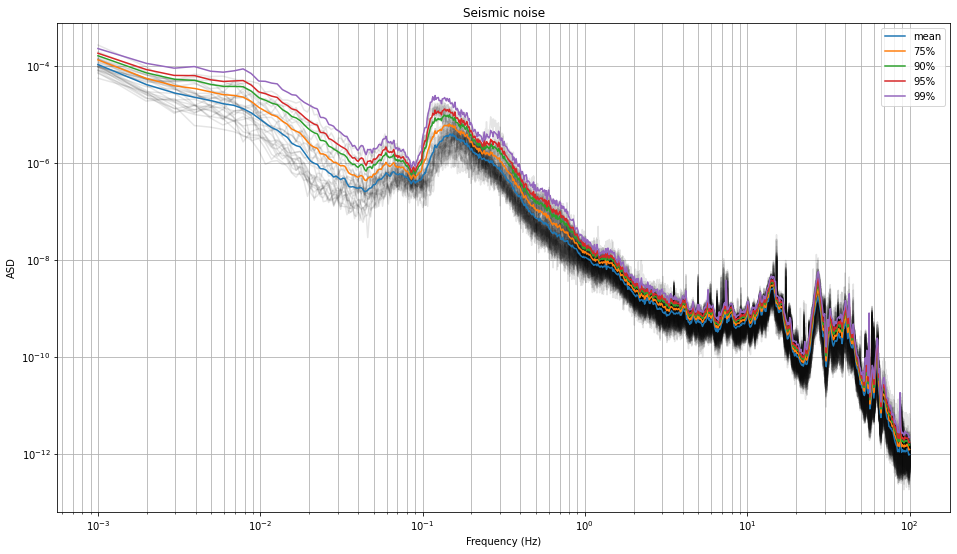

In [8]:
plt.figure(figsize=(16, 9))
plt.title("Seismic noise")

for seismic in seismics:
    plt.loglog(f, seismic, "k", alpha=0.1)
    
plt.loglog(f_, seismic_50r, label="mean")
plt.loglog(f_, seismic_75r, label="75%")
plt.loglog(f_, seismic_90r, label="90%")
plt.loglog(f_, seismic_95r, label="95%")
plt.loglog(f_, seismic_99r, label="99%")

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD")
plt.xlabel("Frequency (Hz)")

In [7]:
# mask = (f_<2e-2)+(f_>7e-1)
# residual_50r = 10**np.interp(np.log10(f_), np.log10(f_[mask]), np.log10(residual_50r[mask]))

In [9]:
# Get corrected SC
h_sc = kontrol.load_transfer_function("sensor_correction_filters/ham4/h_sc_90.pkl")
prefilt = kontrol.load_transfer_function("sensor_correction_filters/ham4/prefilt.pkl")

h_sc *= prefilt

# Get seismic noise
# seismic_50_npz = np.load("noise_spectrums/ham4/seismic_mean.npz")
# seismic_75_npz = np.load("noise_spectrums/ham4/seismic_75.npz")
# seismic_90_npz = np.load("noise_spectrums/ham4/seismic_90.npz")

# seismic_50 = seismic_50_npz["asd"]
# seismic_75 = seismic_75_npz["asd"]
# seismic_90 = seismic_90_npz["asd"]

# Pad
seismic_50r[f_<0.043] = seismic_50r[f_>0.043][0]
seismic_75r[f_<0.043] = seismic_75r[f_>0.043][0]
seismic_90r[f_<0.043] = seismic_90r[f_>0.043][0]
seismic_95r[f_<0.043] = seismic_95r[f_>0.043][0]
seismic_99r[f_<0.043] = seismic_99r[f_>0.043][0]

#Get seismometer noise
seismometer_90_npz = np.load("noise_spectrums/ham4/seismometer_90.npz")

seismometer_90 = seismometer_90_npz["asd"]

# Calculated corrected relative
n_sc_50 = ((abs(h_sc(1j*2*np.pi*f_))*seismometer_90)**2
           + (abs((1-h_sc)(1j*2*np.pi*f_))*seismic_50r)**2)**.5

n_sc_75 = ((abs(h_sc(1j*2*np.pi*f_))*seismometer_90)**2
           + (abs((1-h_sc)(1j*2*np.pi*f_))*seismic_75r)**2)**.5

n_sc_90 = ((abs(h_sc(1j*2*np.pi*f_))*seismometer_90)**2
           + (abs((1-h_sc)(1j*2*np.pi*f_))*seismic_90r)**2)**.5

n_sc_95 = ((abs(h_sc(1j*2*np.pi*f_))*seismometer_90)**2
           + (abs((1-h_sc)(1j*2*np.pi*f_))*seismic_95r)**2)**.5

n_sc_99 = ((abs(h_sc(1j*2*np.pi*f_))*seismometer_90)**2
           + (abs((1-h_sc)(1j*2*np.pi*f_))*seismic_99r)**2)**.5

def noise_model(f, na, nb, a, b):
    noise = ((na/f**a)**2+(nb/f**b)**2)**.5
    return noise
n_ade1_params = [1*10**-10.0625, 2e-10, 0.75, 0]
n_cps = noise_model(f_, *n_ade1_params)

n_rel_50 = (n_cps**2 + n_sc_50**2)**.5
n_rel_75 = (n_cps**2 + n_sc_75**2)**.5
n_rel_90 = (n_cps**2 + n_sc_90**2)**.5
n_rel_95 = (n_cps**2 + n_sc_95**2)**.5
n_rel_99 = (n_cps**2 + n_sc_99**2)**.5

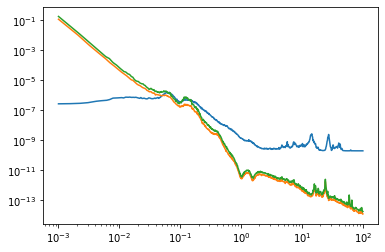

In [10]:
# plt.loglog(f_, seismometer_90)
# plt.loglog(f_, seismic_50)
# plt.loglog(f_, n_cps)
# plt.loglog(f_, n_sc_50)
plt.loglog(f_, n_rel_50)
plt.loglog(f_, residual_50r)
plt.loglog(f_, residual_90r)

In [11]:
residual_50r_pad = residual_50r.copy()
residual_50r_pad[f_<3e-3] = residual_50r[f_>3e-3][0]
residual_50r_pad[f_>20] = residual_50r[f_<20][-1]

residual_90r_pad = residual_90r.copy()
residual_90r_pad[f_<3e-3] = residual_90r[f_>3e-3][0]
residual_90r_pad[f_>20] = residual_90r[f_<20][-1]

n_rel_50_pad = n_rel_50.copy()
n_rel_50_pad[f_<3e-3] = n_rel_50[f_>3e-3][0]
n_rel_50_pad[f_>3] = n_cps[f_<3][-1]

n_rel_75_pad = n_rel_75.copy()
n_rel_75_pad[f_<3e-3] = n_rel_75[f_>3e-3][0]
n_rel_75_pad[f_>3] = n_cps[f_<3][-1]

n_rel_90_pad = n_rel_90.copy()
n_rel_90_pad[f_<3e-3] = n_rel_90[f_>3e-3][0]
n_rel_90_pad[f_>3] = n_cps[f_<3][-1]

n_rel_95_pad = n_rel_95.copy()
n_rel_95_pad[f_<3e-3] = n_rel_95[f_>3e-3][0]
n_rel_95_pad[f_>3] = n_cps[f_<3][-1]

n_rel_99_pad = n_rel_99.copy()
n_rel_99_pad[f_<3e-3] = n_rel_99[f_>3e-3][0]
n_rel_99_pad[f_>3] = n_cps[f_<3][-1]

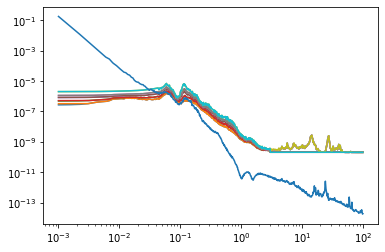

In [12]:
plt.loglog(f_, n_rel_50)
plt.loglog(f_, n_rel_50_pad)

plt.loglog(f_, n_rel_75)
plt.loglog(f_, n_rel_75_pad)

plt.loglog(f_, n_rel_90)
plt.loglog(f_, n_rel_90_pad)

plt.loglog(f_, n_rel_95)
plt.loglog(f_, n_rel_95_pad)
plt.loglog(f_, n_rel_99)
plt.loglog(f_, n_rel_99_pad)

# plt.loglog(f_, residual_50r)
# plt.loglog(f_, residual_50r_pad)
plt.loglog(f_, residual_90r)
# plt.loglog(f_, residual_90r_pad)

In [32]:
#Fit

# n_rel_50_fit = kontrol.curvefit.spectrum_fit(f_, n_rel_50_pad, nzero=4, npole=4)

# n_rel_75_fit = kontrol.curvefit.spectrum_fit(f_, n_rel_75_pad, nzero=6, npole=6)

# n_rel_90_fit = kontrol.curvefit.spectrum_fit(f_, n_rel_90_pad, nzero=4, npole=4)

# n_rel_95_fit = kontrol.curvefit.spectrum_fit(f_, n_rel_95_pad, nzero=4, npole=4)

# n_rel_99_fit = kontrol.curvefit.spectrum_fit(f_, n_rel_99_pad, nzero=4, npole=4)

# residual_50_fit = kontrol.curvefit.spectrum_fit(f_, residual_50r_pad, nzero=8, npole=8)
# residual_90_fit = kontrol.curvefit.spectrum_fit(f_, residual_90r_pad, nzero=10, npole=10)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Frequency (Hz)')

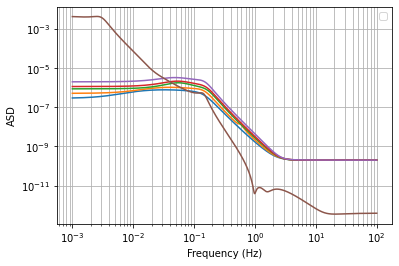

In [33]:
f__ = np.logspace(-3, 2, 1024)
# plt.loglog(f_, n_rel_50_pad)
# plt.loglog(f_, n_rel_75_pad)
# plt.loglog(f_, n_rel_90_pad)
# plt.loglog(f_, residual_90r_pad)
plt.loglog(f__, abs(n_rel_50_fit(1j*2*np.pi*f__)))
plt.loglog(f__, abs(n_rel_75_fit(1j*2*np.pi*f__)))
plt.loglog(f__, abs(n_rel_90_fit(1j*2*np.pi*f__)))
plt.loglog(f__, abs(n_rel_95_fit(1j*2*np.pi*f__)))
plt.loglog(f__, abs(n_rel_99_fit(1j*2*np.pi*f__)))
plt.loglog(f__, abs(residual_90_fit(1j*2*np.pi*f__)))

# plt.loglog(f_, seismic_75r_pad, label="75%")

# plt.loglog(f_, seismic_90r_pad, label="90%")

plt.legend(loc=0)
plt.grid(which="both")
plt.ylabel("ASD")
plt.xlabel("Frequency (Hz)")

In [ ]:
#Note for myself.
#Using h_sc_90 sensor correction filter (weakest against useism)
# Using 90th percentile GS13 noise.

In [15]:
weight = (s+(2*np.pi*10))/(s+(2*np.pi*1)) / 10

In [34]:
comp_50 = kontrol.ComplementaryFilter()
comp_50.noise2 = n_rel_50_fit 
comp_50.noise1 = residual_90_fit * weight
comp_50.weight2 = 1/residual_90_fit / weight
comp_50.weight1 = 1/n_rel_50_fit 

comp_50.h2synthesis()
h2_50, h1_50 = comp_50.hinfsynthesis()

/home/terrencetec/miniconda3/envs/kontrol/lib/python3.10/site-packages/kontrol/core/controlutils.py:656: RuntimeWarning: invalid value encountered in log10
  if (abs(np.log10(num[0]) - np.log10(num[1])) > tol_order


In [17]:
comp_75 = kontrol.ComplementaryFilter()
comp_75.noise2 = n_rel_75_fit 
comp_75.noise1 = residual_90_fit * weight
comp_75.weight2 = 1/residual_90_fit / weight
comp_75.weight1 = 1/n_rel_75_fit 

comp_75.h2synthesis()
h2_75, h1_75 = comp_75.hinfsynthesis()

In [18]:
comp_90 = kontrol.ComplementaryFilter()
comp_90.noise2 = n_rel_90_fit 
comp_90.noise1 = residual_90_fit * weight
comp_90.weight2 = 1/residual_90_fit / weight
comp_90.weight1 = 1/n_rel_90_fit 

comp_90.h2synthesis()
h2_90, h1_90 = comp_90.hinfsynthesis()

In [19]:
comp_95 = kontrol.ComplementaryFilter()
comp_95.noise2 = n_rel_95_fit 
comp_95.noise1 = residual_90_fit * weight
comp_95.weight2 = 1/residual_90_fit / weight
comp_95.weight1 = 1/n_rel_95_fit 

comp_95.h2synthesis()
h2_95, h1_95 = comp_95.hinfsynthesis()

In [20]:
comp_99 = kontrol.ComplementaryFilter()
comp_99.noise2 = n_rel_99_fit 
comp_99.noise1 = residual_90_fit * weight
comp_99.weight2 = 1/residual_90_fit / weight
comp_99.weight1 = 1/n_rel_99_fit 

comp_99.h2synthesis()
h2_99, h1_99 = comp_99.hinfsynthesis()

In [35]:
prefilt = (s/(s+2*np.pi*0.003))**4

h2_50p = prefilt * h2_50
h1_50p = 1-h2_50p

h2_75p = prefilt * h2_75
h1_75p = 1-h2_75p

h2_90p = prefilt * h2_90
h1_90p = 1-h2_90p

h2_95p = prefilt * h2_95
h1_95p = 1-h2_95p

h2_99p = prefilt * h2_99
h1_99p = 1-h2_99p

In [22]:
cml_bb_sc = kontrol.load_transfer_function("sensor_correction_filters/CML_BB_SC.pkl")

cml_bb_sc *= s

In [23]:
ligo_h1 = kontrol.load_transfer_function("complementary_filters/102mHzv2_disp.pkl")
ligo_h2 = kontrol.load_transfer_function("complementary_filters/102mHzv2_inert.pkl")

ligo_h2 /= (s**2 + wn/q*s + wn**2) / s**3

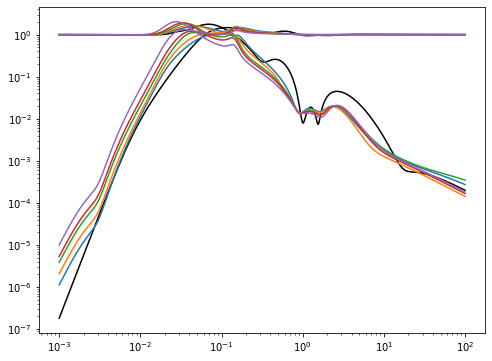

In [42]:
plt.figure(figsize=(8, 6))
# plt.loglog(f_, abs(cml_bb_sc(1j*2*np.pi*f_)), "k")
# plt.loglog(f_, abs((1-cml_bb_sc)(1j*2*np.pi*f_)), "k")

plt.loglog(f_, abs(ligo_h1(1j*2*np.pi*f_)), "k")
plt.loglog(f_, abs(ligo_h2(1j*2*np.pi*f_)), "k")

plt.loglog(f_, abs(h1_50p(1j*2*np.pi*f_)), "C0")
plt.loglog(f_, abs(h2_50p(1j*2*np.pi*f_)), "C0")

plt.loglog(f_, abs(h1_75p(1j*2*np.pi*f_)), "C1")
plt.loglog(f_, abs(h2_75p(1j*2*np.pi*f_)), "C1")

plt.loglog(f_, abs(h1_90p(1j*2*np.pi*f_)), "C2")
plt.loglog(f_, abs(h2_90p(1j*2*np.pi*f_)), "C2")

plt.loglog(f_, abs(h1_95p(1j*2*np.pi*f_)), "C3")
plt.loglog(f_, abs(h2_95p(1j*2*np.pi*f_)), "C3")

plt.loglog(f_, abs(h1_99p(1j*2*np.pi*f_)), "C4")
plt.loglog(f_, abs(h2_99p(1j*2*np.pi*f_)), "C4")

# plt.ylim(1e-1,1)
# plt.xlim(0.1, 1)

In [ ]:
# Do seismic noise 50, 90, 95, 99

In [38]:
kontrol.TransferFunction(h1_50p).save("complementary_filters/ham4/h1_50.pkl")
kontrol.TransferFunction(h1_75p).save("complementary_filters/ham4/h1_75.pkl")
kontrol.TransferFunction(h1_90p).save("complementary_filters/ham4/h1_90.pkl")
kontrol.TransferFunction(h1_95p).save("complementary_filters/ham4/h1_95.pkl")
kontrol.TransferFunction(h1_99p).save("complementary_filters/ham4/h1_99.pkl")

In [39]:
kontrol.TransferFunction(h2_50).save("complementary_filters/ham4/h2_50.pkl")
kontrol.TransferFunction(h2_75).save("complementary_filters/ham4/h2_75.pkl")
kontrol.TransferFunction(h2_90).save("complementary_filters/ham4/h2_90.pkl")
kontrol.TransferFunction(h2_95).save("complementary_filters/ham4/h2_95.pkl")
kontrol.TransferFunction(h2_99).save("complementary_filters/ham4/h2_99.pkl")

In [40]:
kontrol.TransferFunction(prefilt).save("complementary_filters/ham4/h2_prefilt.pkl")